# Integrative analysis of ATAC & RNA - Enrichment analysis
- goal: enrichments of DEA, DEA-clusters & time-series analysis results
- input: DEA & time-series analysis results
- output: enrichment results, summary files & plots

In [1]:
cd ../

/home/sreichl/projects/bmdm-stim


In [2]:
# libraries
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gseapy as gp

In [5]:
# import util functions
import sys
sys.path.insert(1, os.path.join('src'))

import utils_GSEApy

In [4]:
# for relaoding a module
# importlib.reload(utils_GSEApy)

In [6]:
# configs
dir_data = os.path.join('results','INT')
dir_results=os.path.join(dir_data,'enrichment_analysis')

databases = ["ENCODE_TF_ChIP-seq_2015", # TF
             "ChEA_2016", # TF
             "BioPlanet_2019", 
             "KEGG_2019_Mouse", 
             "WikiPathways_2019_Mouse",
             "GO_Biological_Process_2021"
            ]

# more stringent adj.p-value cut-off -> not used anymore
# databases_strict=["BioPlanet_2019", "GO_Biological_Process_2021"]
databases_strict=[]

adj_pvalue=0.05
adj_pvalue_strict=0.01 #  -> not used anymore

In [7]:
if not os.path.exists(dir_results):
        os.mkdir(dir_results)

# load data

In [9]:
# load filtered data for background genes
data = pd.read_csv(os.path.join(dir_data,'INT_counts.csv'), index_col=0, header=0,)
print(data.shape)
data.head()

(45069, 142)


,RNA_PT76_R1_C_albicans_2h,RNA_PT82_R1_C_albicans_24h,RNA_PT76_R1_C_albicans_4h,RNA_PT76_R1_C_albicans_6h,RNA_PT82_R1_C_albicans_8h,RNA_PT76_R1_untreated_0h,RNA_PT82_R1_untreated_24h,RNA_PT76_R1_IFN_beta_2h,RNA_PT82_R1_IFN_beta_24h,RNA_PT76_R1_IFN_beta_4h,...,PT82_R2_IFN_gamma_24h,PT82_R2_IFN_gamma_8h,PT82_R2_LCMV_Cl13_24h,PT82_R2_LCMV_Cl13_8h,PT82_R2_LO28_24h,PT82_R2_LO28_8h,PT82_R2_LPS_24h,PT82_R2_LPS_8h,PT82_R2_untreated_24h,PT82_R2_untreated_8h
ENSMUSG00000098104,1,6,0,2,1,9,4,6,4,0,...,8,7,3,11,31,14,5,12,10,9
ENSMUSG00000033845,219,220,201,169,196,204,226,202,124,153,...,210,109,218,185,32,164,127,155,156,123
ENSMUSG00000025903,115,105,106,113,87,144,128,159,98,137,...,366,204,351,328,65,192,282,150,255,205
ENSMUSG00000033813,63,57,39,74,51,53,68,58,63,124,...,701,414,674,625,113,424,459,357,550,485
ENSMUSG00000033793,315,222,309,250,312,203,277,266,222,218,...,0,5,6,4,12,6,3,5,4,9


In [10]:
# Load sample annotation
annot = pd.read_csv(os.path.join(dir_data,'INT_annotations.csv'), index_col=0, header=0,)
print(annot.shape)
annot.head()

(142, 5)


,library,treatment,time,experiment,group
RNA_PT76_R1_C_albicans_2h,Quant-seq,C_albicans,2h,PT76,C_albicans_2h
RNA_PT82_R1_C_albicans_24h,Quant-seq,C_albicans,24h,PT82,C_albicans_24h
RNA_PT76_R1_C_albicans_4h,Quant-seq,C_albicans,4h,PT76,C_albicans_4h
RNA_PT76_R1_C_albicans_6h,Quant-seq,C_albicans,6h,PT76,C_albicans_6h
RNA_PT82_R1_C_albicans_8h,Quant-seq,C_albicans,8h,PT82,C_albicans_8h


In [11]:
# load gene annotation
gene_annot = pd.read_csv(os.path.join('results','RNA','counts','gene_annotation.tsv'), sep='\t', index_col=0, header=0,)
print(gene_annot.shape)
gene_annot.head()

(55487, 8)


,version,source,external_gene_name,external_gene_source,description,gene_biotype,length,gc
ensembl_gene_id,,,,,,,,
ENSMUSG00000000194,13,ensembl_havana,Gpr107,MGI Symbol,G protein-coupled receptor 107 [Source:MGI Sym...,protein_coding,12766,0.494595
ENSMUSG00000000247,11,ensembl_havana,Lhx2,MGI Symbol,LIM homeobox protein 2 [Source:MGI Symbol;Acc:...,protein_coding,4393,0.597086
ENSMUSG00000000544,14,ensembl_havana,Gpa33,MGI Symbol,glycoprotein A33 (transmembrane) [Source:MGI S...,protein_coding,2742,0.530999
ENSMUSG00000000817,10,ensembl_havana,Fasl,MGI Symbol,"Fas ligand (TNF superfamily, member 6) [Source...",protein_coding,1937,0.430563
ENSMUSG00000000889,8,ensembl_havana,Dbh,MGI Symbol,dopamine beta hydroxylase [Source:MGI Symbol;A...,protein_coding,2692,0.554978


In [12]:
#  prepare list of background genes
background = gene_annot.loc[data.index, 'external_gene_name']
background = list(set(background))
background=[str(x).upper() for x in list(background)]
print(len(background))
background[:5]

44978


['OLFR369-PS1', 'GM26104', 'GM24782', 'GM27421', 'RUVBL2']

In [13]:
treatments = list(annot['treatment'].unique())

# Enrichment analysis

## DEA results

In [14]:
# get significant genes per treatment and time point ie group
gene_lists = dict()

for treatment in treatments:
    # load DEA analysis results per treatment
    tmp_results = pd.read_csv(os.path.join(dir_data,'DEA','INT_DEA_'+treatment+'.csv'), header=0, index_col='rn')
    for group in tmp_results['group'].unique():
        
        for direction in ['up','down']:
            if direction=='up':
                tmp_genes = tmp_results.loc[(tmp_results['adj.P.Val']<0.05) & (tmp_results['group']==group) & (tmp_results['logFC']>0), ].index.unique()
            else:
                tmp_genes = tmp_results.loc[(tmp_results['adj.P.Val']<0.05) & (tmp_results['group']==group) & (tmp_results['logFC']<0), ].index.unique()
        
            if len(tmp_genes)==0:
                continue
            
            gene_lists[group+"_"+direction] = tmp_genes

print(len(gene_lists.keys()))        
gene_lists.keys()

62


dict_keys(['C_albicans_24h_up', 'C_albicans_24h_down', 'C_albicans_2h_up', 'C_albicans_2h_down', 'C_albicans_4h_up', 'C_albicans_4h_down', 'C_albicans_6h_up', 'C_albicans_6h_down', 'C_albicans_8h_up', 'C_albicans_8h_down', 'untreated_0h_up', 'untreated_0h_down', 'IFN_beta_24h_up', 'IFN_beta_24h_down', 'IFN_beta_2h_up', 'IFN_beta_2h_down', 'IFN_beta_4h_up', 'IFN_beta_4h_down', 'IFN_beta_6h_up', 'IFN_beta_6h_down', 'IFN_beta_8h_up', 'IFN_beta_8h_down', 'IFN_gamma_24h_up', 'IFN_gamma_24h_down', 'IFN_gamma_2h_up', 'IFN_gamma_2h_down', 'IFN_gamma_4h_up', 'IFN_gamma_4h_down', 'IFN_gamma_6h_up', 'IFN_gamma_6h_down', 'IFN_gamma_8h_up', 'IFN_gamma_8h_down', 'LCMV_Cl13_24h_up', 'LCMV_Cl13_24h_down', 'LCMV_Cl13_2h_up', 'LCMV_Cl13_2h_down', 'LCMV_Cl13_4h_up', 'LCMV_Cl13_4h_down', 'LCMV_Cl13_6h_up', 'LCMV_Cl13_6h_down', 'LCMV_Cl13_8h_up', 'LCMV_Cl13_8h_down', 'LO28_24h_up', 'LO28_24h_down', 'LO28_2h_up', 'LO28_2h_down', 'LO28_4h_up', 'LO28_4h_down', 'LO28_6h_up', 'LO28_6h_down', 'LO28_8h_up', 'LO28

In [15]:
# convert gene IDs to symbols, and upper-case
for key in gene_lists.keys():
    gene_lists[key] = gene_annot.loc[gene_lists[key], 'external_gene_name']
    gene_lists[key] = list(gene_lists[key])
    gene_lists[key] = [str(x).upper() for x in list(gene_lists[key])]

In [16]:
util_GSEApy.do_enrichment_all(gene_lists=gene_lists, 
                  background=background, 
                  databases=databases, 
                  databases_strict=databases_strict, 
                  adj_pvalue=adj_pvalue, 
                  adj_pvalue_strict=adj_pvalue_strict, 
                  dir_results=os.path.join(dir_results,'DEA'),
                  top_n = 5
                 )

/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 15:19:47,723 Warning: No enrich terms using library CUSTOM46917723252032 when cutoff = 0.05
2021-12-29 15:19:52,639 Warning: No enrich terms using library CUSTOM46917723252032 when cutoff = 0.05
2021-12-29 15:22:15,595 Warning: No enrich terms using library CUSTOM46917723252032 when cutoff = 0.05
2021-12-29 15:25:03,667 Warning: No enrich terms using library CUSTOM46917723252032 when cutoff = 0.05


ChEA_2016


2021-12-29 15:28:02,398 Warning: No enrich terms using library CUSTOM46917894740416 when cutoff = 0.05


BioPlanet_2019


2021-12-29 15:32:23,929 Warning: No enrich terms using library CUSTOM46917959857472 when cutoff = 0.05
2021-12-29 15:32:24,098 Warning: No enrich terms using library CUSTOM46917959857472 when cutoff = 0.05
2021-12-29 15:32:37,365 Warning: No enrich terms using library CUSTOM46917959857472 when cutoff = 0.05
2021-12-29 15:32:54,812 Warning: No enrich terms using library CUSTOM46917959857472 when cutoff = 0.05
2021-12-29 15:32:55,523 Warning: No enrich terms using library CUSTOM46917959857472 when cutoff = 0.05
2021-12-29 15:33:06,561 Warning: No enrich terms using library CUSTOM46917959857472 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 15:33:59,285 Warning: No enrich terms using library CUSTOM46917965101248 when cutoff = 0.05
2021-12-29 15:33:59,552 Warning: No enrich terms using library CUSTOM46917965101248 when cutoff = 0.05
2021-12-29 15:34:06,479 Warning: No enrich terms using library CUSTOM46917965101248 when cutoff = 0.05
2021-12-29 15:34:22,814 Warning: No enrich terms using library CUSTOM46917965101248 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 15:34:49,211 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:49,260 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:49,301 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:49,340 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:53,233 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:58,212 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:58,679 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:34:58,826 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:35:00,506 Warning: No enrich terms using library CUSTOM46917967096704 when cutoff = 0.05
2021-12-29 15:35:04,861 Warning: No enrich terms using library CUSTOM4691

GO_Biological_Process_2021


2021-12-29 15:35:22,830 Warning: No enrich terms using library CUSTOM46917967771136 when cutoff = 0.05
2021-12-29 15:36:45,243 Warning: No enrich terms using library CUSTOM46917967771136 when cutoff = 0.05
2021-12-29 15:37:13,342 Warning: No enrich terms using library CUSTOM46917967771136 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 816
ChEA_2016 645
BioPlanet_2019 995
KEGG_2019_Mouse 260
WikiPathways_2019_Mouse 141
GO_Biological_Process_2021 3163


## DEG clusters

In [17]:
# configs
ks = list(range(4,13))
ks

[4, 5, 6, 7, 8, 9, 10, 11, 12]

In [18]:
for k in ks:
    # get DEG cluster genes
    gene_lists = dict()

    # load clustering results
    DEA_cluster_results = pd.read_csv(os.path.join(dir_data,'DEA','Clusters_HM_{}'.format(k),'Genes.csv'), header=0)
#     DEA_cluster_results = DEA_cluster_results.set_index('rn')
    # make gene lists
    tmp_gene_lists=DEA_cluster_results.groupby('value')['rn'].apply(list).to_dict()

    # rename gene_lists
    for key in tmp_gene_lists.keys():
        gene_lists["cluster_"+str(key)] = tmp_gene_lists[key]

    print(len(gene_lists.keys()))        
    print(gene_lists.keys())

    # convert gene IDs to symbols, and upper-case
    for key in gene_lists.keys():
        gene_lists[key] = gene_annot.loc[gene_lists[key], 'external_gene_name']
        gene_lists[key] = list(gene_lists[key])
        gene_lists[key] = [str(x).upper() for x in list(gene_lists[key])]

    util_GSEApy.do_enrichment_all(gene_lists=gene_lists, 
                      background=background, 
                      databases=databases, 
                      databases_strict=databases_strict, 
                      adj_pvalue=adj_pvalue, 
                      adj_pvalue_strict=adj_pvalue_strict, 
                      dir_results=os.path.join(dir_results,'DEG_clusters','k_{}'.format(k)),
                  top_n = 25
                     )

4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 15:46:41,818 Warning: No enrich terms using library CUSTOM46918164305536 when cutoff = 0.05


ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 813
ChEA_2016 640
BioPlanet_2019 880
KEGG_2019_Mouse 254
WikiPathways_2019_Mouse 113
GO_Biological_Process_2021 2436


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 15:50:19,689 Warning: No enrich terms using library CUSTOM46918225913600 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 15:50:38,478 Warning: No enrich terms using library CUSTOM46917882058880 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 15:50:45,169 Warning: No enrich terms using library CUSTOM46917889199808 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 813
ChEA_2016 639
BioPlanet_2019 865
KEGG_2019_Mouse 254
WikiPathways_2019_Mouse 111
GO_Biological_Process_2021 2334
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 15:54:05,943 Warning: No enrich terms using library CUSTOM46917913242304 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 15:54:26,497 Warning: No enrich terms using library CUSTOM46917872285184 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 15:54:36,885 Warning: No enrich terms using library CUSTOM46917879159872 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 639
BioPlanet_2019 806
KEGG_2019_Mouse 255
WikiPathways_2019_Mouse 102
GO_Biological_Process_2021 2153
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 15:58:30,511 Warning: No enrich terms using library CUSTOM46917951069184 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 15:58:52,160 Warning: No enrich terms using library CUSTOM46917860194432 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 15:59:04,684 Warning: No enrich terms using library CUSTOM46917867331264 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 641
BioPlanet_2019 797
KEGG_2019_Mouse 255
WikiPathways_2019_Mouse 99
GO_Biological_Process_2021 2123
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:03:06,479 Warning: No enrich terms using library CUSTOM46918225819712 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 16:03:29,722 Warning: No enrich terms using library CUSTOM46917847842368 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:03:38,308 Warning: No enrich terms using library CUSTOM46917853016640 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:03:41,910 Warning: No enrich terms using library CUSTOM46917854975232 when cutoff = 0.05
2021-12-29 16:03:42,168 Warning: No enrich terms using library CUSTOM46917854975232 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 641
BioPlanet_2019 797
KEGG_2019_Mouse 255
WikiPathways_2019_Mouse 99
GO_Biological_Process_2021 2178
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:07:49,457 Warning: No enrich terms using library CUSTOM46918262999808 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 16:08:13,419 Warning: No enrich terms using library CUSTOM46917836272448 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:08:23,103 Warning: No enrich terms using library CUSTOM46917841184448 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:08:27,070 Warning: No enrich terms using library CUSTOM46917843143040 when cutoff = 0.05
2021-12-29 16:08:27,317 Warning: No enrich terms using library CUSTOM46917843143040 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 637
BioPlanet_2019 818
KEGG_2019_Mouse 254
WikiPathways_2019_Mouse 102
GO_Biological_Process_2021 2441
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:12:52,431 Warning: No enrich terms using library CUSTOM46918305382784 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 16:13:27,348 Warning: No enrich terms using library CUSTOM46917822448896 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:13:30,121 Warning: No enrich terms using library CUSTOM46917827881088 when cutoff = 0.05
2021-12-29 16:13:32,839 Warning: No enrich terms using library CUSTOM46917827881088 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:13:34,115 Warning: No enrich terms using library CUSTOM46917830105920 when cutoff = 0.05
2021-12-29 16:13:34,270 Warning: No enrich terms using library CUSTOM46917830105920 when cutoff = 0.05
2021-12-29 16:13:35,907 Warning: No enrich terms using library CUSTOM46917830105920 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 16:14:07,767 Warning: No enrich terms using library CUSTOM46917831276736 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 811
ChEA_2016 636
BioPlanet_2019 819
KEGG_2019_Mouse 254
WikiPathways_2019_Mouse 102
GO_Biological_Process_2021 2440
11
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:18:02,399 Warning: No enrich terms using library CUSTOM46918385880320 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 16:18:40,800 Warning: No enrich terms using library CUSTOM46918546838400 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:18:44,057 Warning: No enrich terms using library CUSTOM46918552241984 when cutoff = 0.05
2021-12-29 16:18:47,012 Warning: No enrich terms using library CUSTOM46918552241984 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:18:48,471 Warning: No enrich terms using library CUSTOM46918554229248 when cutoff = 0.05
2021-12-29 16:18:48,627 Warning: No enrich terms using library CUSTOM46918554229248 when cutoff = 0.05
2021-12-29 16:18:50,315 Warning: No enrich terms using library CUSTOM46918554229248 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 16:19:22,197 Warning: No enrich terms using library CUSTOM46918554912640 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 811
ChEA_2016 634
BioPlanet_2019 809
KEGG_2019_Mouse 250
WikiPathways_2019_Mouse 102
GO_Biological_Process_2021 2439
12
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:23:28,026 Warning: No enrich terms using library CUSTOM46918296164480 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 16:24:08,622 Warning: No enrich terms using library CUSTOM46917816466560 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:24:11,428 Warning: No enrich terms using library CUSTOM46917822185664 when cutoff = 0.05
2021-12-29 16:24:16,686 Warning: No enrich terms using library CUSTOM46917822185664 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:24:18,045 Warning: No enrich terms using library CUSTOM46917831766912 when cutoff = 0.05
2021-12-29 16:24:18,192 Warning: No enrich terms using library CUSTOM46917831766912 when cutoff = 0.05
2021-12-29 16:24:20,061 Warning: No enrich terms using library CUSTOM46917831766912 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 16:24:53,112 Warning: No enrich terms using library CUSTOM46917832417536 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 811
ChEA_2016 634
BioPlanet_2019 822
KEGG_2019_Mouse 250
WikiPathways_2019_Mouse 104
GO_Biological_Process_2021 2530


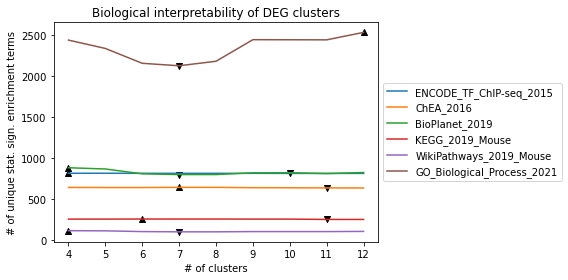

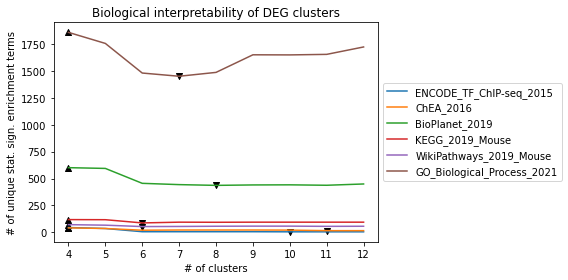

In [19]:
# make plots that show relationship between k and number of unique stat. sign. enrichment terms
plot_sum_df = pd.DataFrame(index=ks, columns=databases)
plot_unique_df = pd.DataFrame(index=ks, columns=databases)

for k in ks:
    for db in databases:
        tmp_results = pd.read_csv(os.path.join(dir_results,'DEG_clusters','k_{}'.format(k), "summary_{}_adjpvalues.csv".format(db)), index_col=0)
        plot_sum_df.loc[k,db]=tmp_results.shape[0]
        plot_unique_df.loc[k,db]=sum((tmp_results<0.05).sum(axis=1)==1)

# make sum plot
plot_sum_df= plot_sum_df.apply(pd.to_numeric)
plot_sum_df.plot.line(figsize=(8,4))
plt.scatter(plot_sum_df.idxmax(), plot_sum_df.max(), marker='^', color='k')
plt.scatter(plot_sum_df.idxmin(), plot_sum_df.min(), marker='v', color='k')
plt.xlabel('# of clusters')
plt.ylabel('# of unique stat. sign. enrichment terms')
plt.title('Biological interpretability of DEG clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(
    fname=os.path.join(dir_results,'DEG_clusters',"Biological_interpretability_sum.svg"),
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# make unique plot
plot_unique_df= plot_unique_df.apply(pd.to_numeric)
plot_unique_df.plot.line(figsize=(8,4))
plt.scatter(plot_unique_df.idxmax(), plot_unique_df.max(), marker='^', color='k')
plt.scatter(plot_unique_df.idxmin(), plot_unique_df.min(), marker='v', color='k')
plt.xlabel('# of clusters')
plt.ylabel('# of unique stat. sign. enrichment terms')
plt.title('Biological interpretability of DEG clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(
    fname=os.path.join(dir_results,'DEG_clusters',"Biological_interpretability_unique.svg"),
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## time-series clusters

In [20]:
# config
ks = list(range(2,11))#+[15,20]
ks

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [21]:
treatments.remove('untreated')

In [ ]:
# get significant genes per treatment and per k clustering
for treatment in treatments:
    for k in ks:
        print("{}_{}".format(treatment,k))

        gene_lists = dict()
        # load clustering result
        tmp_results = pd.read_csv(os.path.join(dir_data,'time_series',treatment, "k_{}".format(k), "clustering_"+treatment+".csv"), header=0, index_col=0)
        # make gene lists
        tmp_gene_lists=tmp_results.groupby('2')['1'].apply(list).to_dict()

        # rename gene_lists
        for key in tmp_gene_lists.keys():
            gene_lists["cluster_"+str(key)] = tmp_gene_lists[key]

        # convert to upper-case
        for key in gene_lists.keys():
            gene_lists[key] = [str(x).upper() for x in list(gene_lists[key])]

        print(len(gene_lists.keys()))        
        print(gene_lists.keys())

        util_GSEApy.do_enrichment_all(gene_lists=gene_lists, 
                          background=background, 
                          databases=databases, 
                          databases_strict=databases_strict, 
                          adj_pvalue=adj_pvalue, 
                          adj_pvalue_strict=adj_pvalue_strict, 
                          dir_results=os.path.join(dir_results,'time_series',treatment, 'k_{}'.format(k)),
                  top_n = 25
                         )

C_albicans_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 699
ChEA_2016 556
BioPlanet_2019 120
KEGG_2019_Mouse 28
WikiPathways_2019_Mouse 14
GO_Biological_Process_2021 463


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)


C_albicans_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 690
ChEA_2016 545
BioPlanet_2019 121
KEGG_2019_Mouse 36
WikiPathways_2019_Mouse 19
GO_Biological_Process_2021 414
C_albicans_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:36:03,634 Warning: No enrich terms using library CUSTOM46918694247616 when cutoff = 0.05


ChEA_2016


2021-12-29 16:36:37,472 Warning: No enrich terms using library CUSTOM46918370367616 when cutoff = 0.05


BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 16:36:50,791 Warning: No enrich terms using library CUSTOM46918147336768 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 694
ChEA_2016 552
BioPlanet_2019 128
KEGG_2019_Mouse 24
WikiPathways_2019_Mouse 22
GO_Biological_Process_2021 428
C_albicans_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:39:32,043 Warning: No enrich terms using library CUSTOM46918318579328 when cutoff = 0.05


ChEA_2016


2021-12-29 16:40:12,928 Warning: No enrich terms using library CUSTOM46918401562496 when cutoff = 0.05


BioPlanet_2019
KEGG_2019_Mouse


2021-12-29 16:40:30,822 Warning: No enrich terms using library CUSTOM46918207151168 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:40:31,176 Warning: No enrich terms using library CUSTOM46918369315712 when cutoff = 0.05
2021-12-29 16:40:31,830 Warning: No enrich terms using library CUSTOM46918369315712 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 675
ChEA_2016 552
BioPlanet_2019 111
KEGG_2019_Mouse 17
WikiPathways_2019_Mouse 22
GO_Biological_Process_2021 401
C_albicans_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:43:15,889 Warning: No enrich terms using library CUSTOM46918233506752 when cutoff = 0.05


ChEA_2016


2021-12-29 16:43:53,116 Warning: No enrich terms using library CUSTOM46918310073024 when cutoff = 0.05
2021-12-29 16:44:01,875 Warning: No enrich terms using library CUSTOM46918310073024 when cutoff = 0.05


BioPlanet_2019


2021-12-29 16:44:08,299 Warning: No enrich terms using library CUSTOM46917875377280 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:44:09,388 Warning: No enrich terms using library CUSTOM46918442953984 when cutoff = 0.05
2021-12-29 16:44:09,789 Warning: No enrich terms using library CUSTOM46918442953984 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:44:10,308 Warning: No enrich terms using library CUSTOM46918167276800 when cutoff = 0.05
2021-12-29 16:44:10,757 Warning: No enrich terms using library CUSTOM46918167276800 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 668
ChEA_2016 549
BioPlanet_2019 133
KEGG_2019_Mouse 17
WikiPathways_2019_Mouse 26
GO_Biological_Process_2021 399
C_albicans_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:46:57,779 Warning: No enrich terms using library CUSTOM46918218510080 when cutoff = 0.05


ChEA_2016


2021-12-29 16:47:31,691 Warning: No enrich terms using library CUSTOM46918419880000 when cutoff = 0.05
2021-12-29 16:47:40,075 Warning: No enrich terms using library CUSTOM46918419880000 when cutoff = 0.05


BioPlanet_2019


2021-12-29 16:47:46,775 Warning: No enrich terms using library CUSTOM46918460083200 when cutoff = 0.05
2021-12-29 16:47:47,711 Warning: No enrich terms using library CUSTOM46917959786944 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:47:48,125 Warning: No enrich terms using library CUSTOM46917959786944 when cutoff = 0.05
2021-12-29 16:47:48,502 Warning: No enrich terms using library CUSTOM46917959786944 when cutoff = 0.05
2021-12-29 16:47:49,154 Warning: No enrich terms using library CUSTOM46918313331776 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:47:49,592 Warning: No enrich terms using library CUSTOM46918313331776 when cutoff = 0.05
2021-12-29 16:47:49,779 Warning: No enrich terms using library CUSTOM46918313331776 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 664
ChEA_2016 542
BioPlanet_2019 116
KEGG_2019_Mouse 28
WikiPathways_2019_Mouse 17
GO_Biological_Process_2021 470
C_albicans_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:50:34,600 Warning: No enrich terms using library CUSTOM46917921870976 when cutoff = 0.05
2021-12-29 16:50:37,716 Warning: No enrich terms using library CUSTOM46917921870976 when cutoff = 0.05
2021-12-29 16:50:53,748 Warning: No enrich terms using library CUSTOM46917921870976 when cutoff = 0.05
2021-12-29 16:51:01,089 Warning: No enrich terms using library CUSTOM46917921870976 when cutoff = 0.05


ChEA_2016


2021-12-29 16:51:06,010 Warning: No enrich terms using library CUSTOM46917968037504 when cutoff = 0.05
2021-12-29 16:51:17,144 Warning: No enrich terms using library CUSTOM46917968037504 when cutoff = 0.05


BioPlanet_2019


2021-12-29 16:51:21,135 Warning: No enrich terms using library CUSTOM46917895578880 when cutoff = 0.05
2021-12-29 16:51:21,244 Warning: No enrich terms using library CUSTOM46917895578880 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:51:22,996 Warning: No enrich terms using library CUSTOM46918447547648 when cutoff = 0.05
2021-12-29 16:51:23,053 Warning: No enrich terms using library CUSTOM46918447547648 when cutoff = 0.05
2021-12-29 16:51:23,252 Warning: No enrich terms using library CUSTOM46918413019200 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:51:24,184 Warning: No enrich terms using library CUSTOM46918413019200 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 16:51:30,612 Warning: No enrich terms using library CUSTOM46918327348928 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 683
ChEA_2016 550
BioPlanet_2019 123
KEGG_2019_Mouse 58
WikiPathways_2019_Mouse 25
GO_Biological_Process_2021 653
C_albicans_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:54:17,045 Warning: No enrich terms using library CUSTOM46918555086656 when cutoff = 0.05
2021-12-29 16:54:30,401 Warning: No enrich terms using library CUSTOM46918555086656 when cutoff = 0.05
2021-12-29 16:54:36,419 Warning: No enrich terms using library CUSTOM46918555086656 when cutoff = 0.05
2021-12-29 16:54:36,889 Warning: No enrich terms using library CUSTOM46918555086656 when cutoff = 0.05


ChEA_2016


2021-12-29 16:54:42,446 Warning: No enrich terms using library CUSTOM46918129204160 when cutoff = 0.05
2021-12-29 16:54:51,961 Warning: No enrich terms using library CUSTOM46918129204160 when cutoff = 0.05
2021-12-29 16:54:53,705 Warning: No enrich terms using library CUSTOM46918129204160 when cutoff = 0.05


BioPlanet_2019


2021-12-29 16:54:57,238 Warning: No enrich terms using library CUSTOM46918389475136 when cutoff = 0.05
2021-12-29 16:54:57,291 Warning: No enrich terms using library CUSTOM46918389475136 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:54:57,880 Warning: No enrich terms using library CUSTOM46918263716544 when cutoff = 0.05
2021-12-29 16:54:58,857 Warning: No enrich terms using library CUSTOM46918263716544 when cutoff = 0.05
2021-12-29 16:54:58,887 Warning: No enrich terms using library CUSTOM46918263716544 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:54:59,109 Warning: No enrich terms using library CUSTOM46917922600832 when cutoff = 0.05
2021-12-29 16:54:59,152 Warning: No enrich terms using library CUSTOM46917922600832 when cutoff = 0.05
2021-12-29 16:54:59,756 Warning: No enrich terms using library CUSTOM46917922600832 when cutoff = 0.05
2021-12-29 16:54:59,776 Warning: No enrich terms using library CUSTOM46917922600832 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 695
ChEA_2016 554
BioPlanet_2019 143
KEGG_2019_Mouse 54
WikiPathways_2019_Mouse 19
GO_Biological_Process_2021 861
C_albicans_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 16:57:49,302 Warning: No enrich terms using library CUSTOM46918253492800 when cutoff = 0.05
2021-12-29 16:57:52,557 Warning: No enrich terms using library CUSTOM46918253492800 when cutoff = 0.05
2021-12-29 16:58:13,657 Warning: No enrich terms using library CUSTOM46918253492800 when cutoff = 0.05
2021-12-29 16:58:15,867 Warning: No enrich terms using library CUSTOM46918253492800 when cutoff = 0.05


ChEA_2016


2021-12-29 16:58:20,147 Warning: No enrich terms using library CUSTOM46918140461312 when cutoff = 0.05
2021-12-29 16:58:23,378 Warning: No enrich terms using library CUSTOM46918140461312 when cutoff = 0.05
2021-12-29 16:58:32,217 Warning: No enrich terms using library CUSTOM46918140461312 when cutoff = 0.05
2021-12-29 16:58:32,772 Warning: No enrich terms using library CUSTOM46918140461312 when cutoff = 0.05


BioPlanet_2019


2021-12-29 16:58:36,004 Warning: No enrich terms using library CUSTOM46918570310720 when cutoff = 0.05
2021-12-29 16:58:36,088 Warning: No enrich terms using library CUSTOM46918570310720 when cutoff = 0.05
2021-12-29 16:58:36,183 Warning: No enrich terms using library CUSTOM46918570310720 when cutoff = 0.05
2021-12-29 16:58:36,255 Warning: No enrich terms using library CUSTOM46918157019328 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 16:58:36,647 Warning: No enrich terms using library CUSTOM46918157019328 when cutoff = 0.05
2021-12-29 16:58:37,735 Warning: No enrich terms using library CUSTOM46918157019328 when cutoff = 0.05
2021-12-29 16:58:37,777 Warning: No enrich terms using library CUSTOM46918157019328 when cutoff = 0.05
2021-12-29 16:58:37,814 Warning: No enrich terms using library CUSTOM46918157019328 when cutoff = 0.05
2021-12-29 16:58:37,845 Warning: No enrich terms using library CUSTOM46918321070784 when cutoff = 0.05
2021-12-29 16:58:37,882 Warning: No enrich terms using library CUSTOM46918321070784 when cutoff = 0.05
2021-12-29 16:58:37,933 Warning: No enrich terms using library CUSTOM46918321070784 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 16:58:38,757 Warning: No enrich terms using library CUSTOM46918321070784 when cutoff = 0.05
2021-12-29 16:58:38,955 Warning: No enrich terms using library CUSTOM46918321070784 when cutoff = 0.05
2021-12-29 16:58:39,155 Warning: No enrich terms using library CUSTOM46918348406848 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 668
ChEA_2016 539
BioPlanet_2019 138
KEGG_2019_Mouse 56
WikiPathways_2019_Mouse 32
GO_Biological_Process_2021 1047
IFN_beta_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 805
ChEA_2016 626
BioPlanet_2019 352
KEGG_2019_Mouse 149
WikiPathways_2019_Mouse 71
GO_Biological_Process_2021 1245
IFN_beta_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 808
ChEA_2016 626
BioPlanet_2019 368
KEGG_2019_Mouse 154
WikiPathways_2019_Mouse 68
GO_Biological_Process_2021 1251
IFN_beta_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 807
ChEA_2016 627
BioPlanet_2019 337
KEGG_2019_Mouse 134
WikiPathways_2019_Mouse 63
GO_Biological_Process_2021 1139
IFN_beta_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 17:12:28,754 Warning: No enrich terms using library CUSTOM46918583289856 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 806
ChEA_2016 626
BioPlanet_2019 341
KEGG_2019_Mouse 137
WikiPathways_2019_Mouse 66
GO_Biological_Process_2021 1122
IFN_beta_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 17:16:44,924 Warning: No enrich terms using library CUSTOM46918165974592 when cutoff = 0.05
2021-12-29 17:16:45,794 Warning: No enrich terms using library CUSTOM46918165974592 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 806
ChEA_2016 623
BioPlanet_2019 346
KEGG_2019_Mouse 143
WikiPathways_2019_Mouse 59
GO_Biological_Process_2021 1131
IFN_beta_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 17:21:10,543 Warning: No enrich terms using library CUSTOM46918769032128 when cutoff = 0.05
2021-12-29 17:21:11,280 Warning: No enrich terms using library CUSTOM46918769032128 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 807
ChEA_2016 625
BioPlanet_2019 361
KEGG_2019_Mouse 147
WikiPathways_2019_Mouse 65
GO_Biological_Process_2021 1138
IFN_beta_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 17:25:46,065 Warning: No enrich terms using library CUSTOM46918808649280 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 808
ChEA_2016 626
BioPlanet_2019 322
KEGG_2019_Mouse 122
WikiPathways_2019_Mouse 54
GO_Biological_Process_2021 1152
IFN_beta_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 17:30:24,365 Warning: No enrich terms using library CUSTOM46918725678720 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 17:30:31,722 Warning: No enrich terms using library CUSTOM46918732967104 when cutoff = 0.05
2021-12-29 17:30:32,244 Warning: No enrich terms using library CUSTOM46918732967104 when cutoff = 0.05
2021-12-29 17:30:32,384 Warning: No enrich terms using library CUSTOM46918732967104 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 808
ChEA_2016 626
BioPlanet_2019 358
KEGG_2019_Mouse 127
WikiPathways_2019_Mouse 63
GO_Biological_Process_2021 1139
IFN_beta_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 17:35:34,730 Warning: No enrich terms using library CUSTOM46918211987136 when cutoff = 0.05
2021-12-29 17:35:36,710 Warning: No enrich terms using library CUSTOM46918211987136 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 17:35:44,504 Warning: No enrich terms using library CUSTOM46918138379136 when cutoff = 0.05
2021-12-29 17:35:45,019 Warning: No enrich terms using library CUSTOM46918138379136 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 808
ChEA_2016 625
BioPlanet_2019 322
KEGG_2019_Mouse 120
WikiPathways_2019_Mouse 62
GO_Biological_Process_2021 1051
IFN_gamma_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 598
ChEA_2016 564
BioPlanet_2019 183
KEGG_2019_Mouse 104
WikiPathways_2019_Mouse 37
GO_Biological_Process_2021 400
IFN_gamma_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 591
ChEA_2016 556
BioPlanet_2019 152
KEGG_2019_Mouse 97
WikiPathways_2019_Mouse 39
GO_Biological_Process_2021 344
IFN_gamma_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 596
ChEA_2016 558
BioPlanet_2019 129
KEGG_2019_Mouse 72
WikiPathways_2019_Mouse 32
GO_Biological_Process_2021 312
IFN_gamma_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 17:49:32,790 Warning: No enrich terms using library CUSTOM46919240595008 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 17:49:56,868 Warning: No enrich terms using library CUSTOM46919401884864 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 17:50:03,177 Warning: No enrich terms using library CUSTOM46919407198336 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 17:50:04,328 Warning: No enrich terms using library CUSTOM46919409201984 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 590
ChEA_2016 556
BioPlanet_2019 156
KEGG_2019_Mouse 91
WikiPathways_2019_Mouse 33
GO_Biological_Process_2021 344
IFN_gamma_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 17:53:13,538 Warning: No enrich terms using library CUSTOM46919240423040 when cutoff = 0.05


ChEA_2016


2021-12-29 17:53:39,638 Warning: No enrich terms using library CUSTOM46918282344768 when cutoff = 0.05


BioPlanet_2019


2021-12-29 17:53:48,387 Warning: No enrich terms using library CUSTOM46918313651200 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 17:53:50,653 Warning: No enrich terms using library CUSTOM46917879988416 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 17:53:51,891 Warning: No enrich terms using library CUSTOM46917812768256 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 633
ChEA_2016 557
BioPlanet_2019 148
KEGG_2019_Mouse 84
WikiPathways_2019_Mouse 28
GO_Biological_Process_2021 307
IFN_gamma_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 17:57:06,006 Warning: No enrich terms using library CUSTOM46918456948864 when cutoff = 0.05


ChEA_2016
BioPlanet_2019


2021-12-29 17:57:47,581 Warning: No enrich terms using library CUSTOM46918963785408 when cutoff = 0.05
2021-12-29 17:57:49,172 Warning: No enrich terms using library CUSTOM46918963785408 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 17:57:51,818 Warning: No enrich terms using library CUSTOM46919004381824 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 17:57:52,938 Warning: No enrich terms using library CUSTOM46919006389568 when cutoff = 0.05
2021-12-29 17:57:53,435 Warning: No enrich terms using library CUSTOM46919006389568 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 664
ChEA_2016 561
BioPlanet_2019 165
KEGG_2019_Mouse 92
WikiPathways_2019_Mouse 32
GO_Biological_Process_2021 356
IFN_gamma_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:01:39,588 Warning: No enrich terms using library CUSTOM46919005242048 when cutoff = 0.05


ChEA_2016


2021-12-29 18:02:01,756 Warning: No enrich terms using library CUSTOM46918773685248 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:02:08,854 Warning: No enrich terms using library CUSTOM46918315791744 when cutoff = 0.05
2021-12-29 18:02:08,952 Warning: No enrich terms using library CUSTOM46918315791744 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:02:11,486 Warning: No enrich terms using library CUSTOM46918227009984 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:02:12,779 Warning: No enrich terms using library CUSTOM46917865393088 when cutoff = 0.05
2021-12-29 18:02:12,803 Warning: No enrich terms using library CUSTOM46917865393088 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 18:02:17,896 Warning: No enrich terms using library CUSTOM46918253664576 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 654
ChEA_2016 554
BioPlanet_2019 167
KEGG_2019_Mouse 102
WikiPathways_2019_Mouse 37
GO_Biological_Process_2021 353
IFN_gamma_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:05:31,740 Warning: No enrich terms using library CUSTOM46919023037632 when cutoff = 0.05
2021-12-29 18:05:49,836 Warning: No enrich terms using library CUSTOM46919023037632 when cutoff = 0.05


ChEA_2016


2021-12-29 18:06:07,337 Warning: No enrich terms using library CUSTOM46918558418880 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:06:20,486 Warning: No enrich terms using library CUSTOM46918915576640 when cutoff = 0.05
2021-12-29 18:06:20,636 Warning: No enrich terms using library CUSTOM46918915576640 when cutoff = 0.05
2021-12-29 18:06:21,611 Warning: No enrich terms using library CUSTOM46918915576640 when cutoff = 0.05
2021-12-29 18:06:22,451 Warning: No enrich terms using library CUSTOM46918921021120 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:06:23,818 Warning: No enrich terms using library CUSTOM46918921021120 when cutoff = 0.05
2021-12-29 18:06:25,071 Warning: No enrich terms using library CUSTOM46918923278720 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:06:25,817 Warning: No enrich terms using library CUSTOM46918923278720 when cutoff = 0.05
2021-12-29 18:06:25,851 Warning: No enrich terms using library CUSTOM46918923278720 when cutoff = 0.05
2021-12-29 18:06:26,148 Warning: No enrich terms using library CUSTOM46918923278720 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 607
ChEA_2016 546
BioPlanet_2019 151
KEGG_2019_Mouse 95
WikiPathways_2019_Mouse 40
GO_Biological_Process_2021 274
IFN_gamma_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:09:47,406 Warning: No enrich terms using library CUSTOM46919139190272 when cutoff = 0.05
2021-12-29 18:10:01,387 Warning: No enrich terms using library CUSTOM46919139190272 when cutoff = 0.05


ChEA_2016


2021-12-29 18:10:30,175 Warning: No enrich terms using library CUSTOM46919310135552 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:10:45,342 Warning: No enrich terms using library CUSTOM46919378902080 when cutoff = 0.05
2021-12-29 18:10:45,491 Warning: No enrich terms using library CUSTOM46919378902080 when cutoff = 0.05
2021-12-29 18:10:46,410 Warning: No enrich terms using library CUSTOM46919378902080 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:10:49,018 Warning: No enrich terms using library CUSTOM46919384718912 when cutoff = 0.05
2021-12-29 18:10:50,198 Warning: No enrich terms using library CUSTOM46919384718912 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:10:50,985 Warning: No enrich terms using library CUSTOM46919386755392 when cutoff = 0.05
2021-12-29 18:10:51,015 Warning: No enrich terms using library CUSTOM46919386755392 when cutoff = 0.05
2021-12-29 18:10:51,337 Warning: No enrich terms using library CUSTOM46919386755392 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 606
ChEA_2016 557
BioPlanet_2019 117
KEGG_2019_Mouse 98
WikiPathways_2019_Mouse 32
GO_Biological_Process_2021 457
LCMV_Cl13_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 731
ChEA_2016 580
BioPlanet_2019 186
KEGG_2019_Mouse 98
WikiPathways_2019_Mouse 31
GO_Biological_Process_2021 583
LCMV_Cl13_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 730
ChEA_2016 583
BioPlanet_2019 200
KEGG_2019_Mouse 80
WikiPathways_2019_Mouse 26
GO_Biological_Process_2021 567
LCMV_Cl13_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016


2021-12-29 18:20:26,773 Warning: No enrich terms using library CUSTOM46919303512768 when cutoff = 0.05


BioPlanet_2019
KEGG_2019_Mouse


2021-12-29 18:20:39,163 Warning: No enrich terms using library CUSTOM46919396966848 when cutoff = 0.05


WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 727
ChEA_2016 566
BioPlanet_2019 167
KEGG_2019_Mouse 94
WikiPathways_2019_Mouse 28
GO_Biological_Process_2021 505
LCMV_Cl13_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016


2021-12-29 18:24:02,453 Warning: No enrich terms using library CUSTOM46919639227008 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:24:14,900 Warning: No enrich terms using library CUSTOM46919704364544 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:24:17,545 Warning: No enrich terms using library CUSTOM46919709653376 when cutoff = 0.05


WikiPathways_2019_Mouse
GO_Biological_Process_2021


2021-12-29 18:24:23,615 Warning: No enrich terms using library CUSTOM46919712356800 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 702
ChEA_2016 571
BioPlanet_2019 197
KEGG_2019_Mouse 114
WikiPathways_2019_Mouse 36
GO_Biological_Process_2021 546
LCMV_Cl13_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:27:12,011 Warning: No enrich terms using library CUSTOM46919748087680 when cutoff = 0.05


ChEA_2016


2021-12-29 18:27:56,940 Warning: No enrich terms using library CUSTOM46918139712704 when cutoff = 0.05
2021-12-29 18:28:02,795 Warning: No enrich terms using library CUSTOM46918139712704 when cutoff = 0.05
2021-12-29 18:28:16,201 Warning: No enrich terms using library CUSTOM46918222886848 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:28:17,397 Warning: No enrich terms using library CUSTOM46918222886848 when cutoff = 0.05
2021-12-29 18:28:19,668 Warning: No enrich terms using library CUSTOM46917811551872 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:28:20,271 Warning: No enrich terms using library CUSTOM46917811551872 when cutoff = 0.05
2021-12-29 18:28:21,566 Warning: No enrich terms using library CUSTOM46918364751488 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:28:22,882 Warning: No enrich terms using library CUSTOM46918746936448 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 18:28:25,533 Warning: No enrich terms using library CUSTOM46918746936448 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 723
ChEA_2016 571
BioPlanet_2019 225
KEGG_2019_Mouse 122
WikiPathways_2019_Mouse 39
GO_Biological_Process_2021 635
LCMV_Cl13_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:31:11,486 Warning: No enrich terms using library CUSTOM46919388741440 when cutoff = 0.05


ChEA_2016


2021-12-29 18:32:01,716 Warning: No enrich terms using library CUSTOM46919389149760 when cutoff = 0.05
2021-12-29 18:32:08,315 Warning: No enrich terms using library CUSTOM46919389149760 when cutoff = 0.05
2021-12-29 18:32:22,779 Warning: No enrich terms using library CUSTOM46919405789952 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:32:23,353 Warning: No enrich terms using library CUSTOM46919405789952 when cutoff = 0.05
2021-12-29 18:32:26,602 Warning: No enrich terms using library CUSTOM46918947133184 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:32:26,949 Warning: No enrich terms using library CUSTOM46918947133184 when cutoff = 0.05
2021-12-29 18:32:28,536 Warning: No enrich terms using library CUSTOM46919412895552 when cutoff = 0.05


WikiPathways_2019_Mouse
GO_Biological_Process_2021


2021-12-29 18:32:31,806 Warning: No enrich terms using library CUSTOM46919016144512 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 722
ChEA_2016 568
BioPlanet_2019 195
KEGG_2019_Mouse 104
WikiPathways_2019_Mouse 34
GO_Biological_Process_2021 583
LCMV_Cl13_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:36:01,721 Warning: No enrich terms using library CUSTOM46919153066432 when cutoff = 0.05


ChEA_2016


2021-12-29 18:36:13,704 Warning: No enrich terms using library CUSTOM46919338392704 when cutoff = 0.05
2021-12-29 18:36:32,299 Warning: No enrich terms using library CUSTOM46919338392704 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:36:40,609 Warning: No enrich terms using library CUSTOM46919568140288 when cutoff = 0.05
2021-12-29 18:36:40,899 Warning: No enrich terms using library CUSTOM46919568140288 when cutoff = 0.05
2021-12-29 18:36:42,418 Warning: No enrich terms using library CUSTOM46919568140288 when cutoff = 0.05
2021-12-29 18:36:42,708 Warning: No enrich terms using library CUSTOM46919568140288 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:36:43,718 Warning: No enrich terms using library CUSTOM46919574178688 when cutoff = 0.05
2021-12-29 18:36:44,785 Warning: No enrich terms using library CUSTOM46919574178688 when cutoff = 0.05
2021-12-29 18:36:44,888 Warning: No enrich terms using library CUSTOM46919574178688 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:36:45,669 Warning: No enrich terms using library CUSTOM46919576452672 when cutoff = 0.05
2021-12-29 18:36:46,439 Warning: No enrich terms using library CUSTOM46919576452672 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 18:36:47,811 Warning: No enrich terms using library CUSTOM46919577131968 when cutoff = 0.05
2021-12-29 18:36:53,472 Warning: No enrich terms using library CUSTOM46919577131968 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 696
ChEA_2016 568
BioPlanet_2019 232
KEGG_2019_Mouse 124
WikiPathways_2019_Mouse 38
GO_Biological_Process_2021 723
LCMV_Cl13_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:40:17,305 Warning: No enrich terms using library CUSTOM46919664246592 when cutoff = 0.05


ChEA_2016


2021-12-29 18:40:37,499 Warning: No enrich terms using library CUSTOM46919810021952 when cutoff = 0.05
2021-12-29 18:40:55,543 Warning: No enrich terms using library CUSTOM46919810021952 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:41:04,779 Warning: No enrich terms using library CUSTOM46919874885056 when cutoff = 0.05
2021-12-29 18:41:05,047 Warning: No enrich terms using library CUSTOM46919874885056 when cutoff = 0.05
2021-12-29 18:41:06,383 Warning: No enrich terms using library CUSTOM46919874885056 when cutoff = 0.05
2021-12-29 18:41:06,609 Warning: No enrich terms using library CUSTOM46919874885056 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:41:08,436 Warning: No enrich terms using library CUSTOM46919880427840 when cutoff = 0.05
2021-12-29 18:41:08,530 Warning: No enrich terms using library CUSTOM46919880427840 when cutoff = 0.05
2021-12-29 18:41:15,025 Warning: No enrich terms using library CUSTOM46919880427840 when cutoff = 0.05
2021-12-29 18:41:15,125 Warning: No enrich terms using library CUSTOM46919880427840 when cutoff = 0.05
2021-12-29 18:41:16,069 Warning: No enrich terms using library CUSTOM46919882435584 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:41:16,117 Warning: No enrich terms using library CUSTOM46919882435584 when cutoff = 0.05
2021-12-29 18:41:16,917 Warning: No enrich terms using library CUSTOM46919882435584 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 18:41:18,582 Warning: No enrich terms using library CUSTOM46919883118208 when cutoff = 0.05
2021-12-29 18:41:23,759 Warning: No enrich terms using library CUSTOM46919883118208 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 695
ChEA_2016 567
BioPlanet_2019 231
KEGG_2019_Mouse 109
WikiPathways_2019_Mouse 37
GO_Biological_Process_2021 659
LCMV_Cl13_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015


2021-12-29 18:44:59,559 Warning: No enrich terms using library CUSTOM46919732369664 when cutoff = 0.05


ChEA_2016


2021-12-29 18:45:08,945 Warning: No enrich terms using library CUSTOM46917950039040 when cutoff = 0.05
2021-12-29 18:45:27,472 Warning: No enrich terms using library CUSTOM46917950039040 when cutoff = 0.05


BioPlanet_2019


2021-12-29 18:45:31,310 Warning: No enrich terms using library CUSTOM46919038963840 when cutoff = 0.05
2021-12-29 18:45:31,604 Warning: No enrich terms using library CUSTOM46919038963840 when cutoff = 0.05
2021-12-29 18:45:32,824 Warning: No enrich terms using library CUSTOM46919038963840 when cutoff = 0.05
2021-12-29 18:45:33,038 Warning: No enrich terms using library CUSTOM46919038963840 when cutoff = 0.05
2021-12-29 18:45:34,499 Warning: No enrich terms using library CUSTOM46919038963840 when cutoff = 0.05


KEGG_2019_Mouse


2021-12-29 18:45:34,897 Warning: No enrich terms using library CUSTOM46918416781120 when cutoff = 0.05
2021-12-29 18:45:35,004 Warning: No enrich terms using library CUSTOM46918416781120 when cutoff = 0.05
2021-12-29 18:45:35,754 Warning: No enrich terms using library CUSTOM46918416781120 when cutoff = 0.05
2021-12-29 18:45:35,859 Warning: No enrich terms using library CUSTOM46918416781120 when cutoff = 0.05
2021-12-29 18:45:36,752 Warning: No enrich terms using library CUSTOM46918416781120 when cutoff = 0.05


WikiPathways_2019_Mouse


2021-12-29 18:45:37,748 Warning: No enrich terms using library CUSTOM46918571648960 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 18:45:39,377 Warning: No enrich terms using library CUSTOM46918127618240 when cutoff = 0.05
2021-12-29 18:45:43,551 Warning: No enrich terms using library CUSTOM46918127618240 when cutoff = 0.05
2021-12-29 18:45:46,792 Warning: No enrich terms using library CUSTOM46918127618240 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 694
ChEA_2016 563
BioPlanet_2019 238
KEGG_2019_Mouse 107
WikiPathways_2019_Mouse 33
GO_Biological_Process_2021 683
LO28_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 813
ChEA_2016 636
BioPlanet_2019 672
KEGG_2019_Mouse 213
WikiPathways_2019_Mouse 84
GO_Biological_Process_2021 1698
LO28_3
3
dict_keys(['cluster_1', 'cluster_2', 'cluster_3'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 635
BioPlanet_2019 634
KEGG_2019_Mouse 212
WikiPathways_2019_Mouse 82
GO_Biological_Process_2021 1619
LO28_4
4
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 636
BioPlanet_2019 644
KEGG_2019_Mouse 218
WikiPathways_2019_Mouse 90
GO_Biological_Process_2021 1626
LO28_5
5
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019
KEGG_2019_Mouse
WikiPathways_2019_Mouse
GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 635
BioPlanet_2019 637
KEGG_2019_Mouse 201
WikiPathways_2019_Mouse 91
GO_Biological_Process_2021 1588
LO28_6
6
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 19:03:42,125 Warning: No enrich terms using library CUSTOM46919485189632 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 19:03:55,415 Warning: No enrich terms using library CUSTOM46919353006144 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 19:04:02,554 Warning: No enrich terms using library CUSTOM46919422656128 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 810
ChEA_2016 638
BioPlanet_2019 672
KEGG_2019_Mouse 209
WikiPathways_2019_Mouse 92
GO_Biological_Process_2021 1634
LO28_7
7
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 19:08:37,990 Warning: No enrich terms using library CUSTOM46919696380928 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 19:08:59,917 Warning: No enrich terms using library CUSTOM46919709080128 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 811
ChEA_2016 640
BioPlanet_2019 624
KEGG_2019_Mouse 203
WikiPathways_2019_Mouse 86
GO_Biological_Process_2021 1633
LO28_8
8
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 19:13:39,940 Warning: No enrich terms using library CUSTOM46920128948096 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 19:13:53,638 Warning: No enrich terms using library CUSTOM46920136998336 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 19:14:04,624 Warning: No enrich terms using library CUSTOM46920137685824 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 811
ChEA_2016 641
BioPlanet_2019 594
KEGG_2019_Mouse 210
WikiPathways_2019_Mouse 88
GO_Biological_Process_2021 1617
LO28_9
9
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 19:18:49,886 Warning: No enrich terms using library CUSTOM46918321252544 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 19:19:04,256 Warning: No enrich terms using library CUSTOM46918494983040 when cutoff = 0.05


GO_Biological_Process_2021
ENCODE_TF_ChIP-seq_2015 811
ChEA_2016 638
BioPlanet_2019 636
KEGG_2019_Mouse 201
WikiPathways_2019_Mouse 87
GO_Biological_Process_2021 1677
LO28_10
10
dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly a

ENCODE_TF_ChIP-seq_2015
ChEA_2016
BioPlanet_2019


2021-12-29 19:24:19,672 Warning: No enrich terms using library CUSTOM46919272516160 when cutoff = 0.05


KEGG_2019_Mouse
WikiPathways_2019_Mouse


2021-12-29 19:24:27,214 Warning: No enrich terms using library CUSTOM46918961145600 when cutoff = 0.05
2021-12-29 19:24:29,674 Warning: No enrich terms using library CUSTOM46918961145600 when cutoff = 0.05


GO_Biological_Process_2021


2021-12-29 19:24:41,542 Warning: No enrich terms using library CUSTOM46919416067904 when cutoff = 0.05


ENCODE_TF_ChIP-seq_2015 812
ChEA_2016 633
BioPlanet_2019 651
KEGG_2019_Mouse 200
WikiPathways_2019_Mouse 85
GO_Biological_Process_2021 1644
LPS_2
2
dict_keys(['cluster_1', 'cluster_2'])


/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nobackup/lab_bock/users/sreichl/miniconda3/envs/enrichment_analysis/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maayanlab.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
# make plots that show relationship between k and number of unique stat. sign. enrichment terms
for treatment in treatments:
    plot_sum_df = pd.DataFrame(index=ks, columns=databases)
    plot_unique_df = pd.DataFrame(index=ks, columns=databases)
    for k in ks:
        for db in databases:
            tmp_results = pd.read_csv(os.path.join(dir_results,'time_series',treatment,"k_{}".format(k), "summary_{}_adjpvalues.csv".format(db)), index_col=0)
            plot_sum_df.loc[k,db]=tmp_results.shape[0]
            plot_unique_df.loc[k,db]=sum((tmp_results<0.05).sum(axis=1)==1)
    
    # make sum plot
    plot_sum_df= plot_sum_df.apply(pd.to_numeric)
    plot_sum_df.plot.line(figsize=(8,4))
    plt.scatter(plot_sum_df.idxmax(), plot_sum_df.max(), marker='^', color='k')
    plt.scatter(plot_sum_df.idxmin(), plot_sum_df.min(), marker='v', color='k')
    plt.xlabel('# of clusters')
    plt.ylabel('# of unique stat. sign. enrichment terms')
    plt.title('Biological interpretability of {} time-series clusters'.format(treatment))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join(dir_results,'time_series',treatment,"Biological_interpretability_sum_"+treatment+".svg"),
        format="svg",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()
    
    # make unique plot
    plot_unique_df= plot_unique_df.apply(pd.to_numeric)
    plot_unique_df.plot.line(figsize=(8,4))
    plt.scatter(plot_unique_df.idxmax(), plot_unique_df.max(), marker='^', color='k')
    plt.scatter(plot_unique_df.idxmin(), plot_unique_df.min(), marker='v', color='k')
    plt.xlabel('# of clusters')
    plt.ylabel('# of unique stat. sign. enrichment terms')
    plt.title('Biological interpretability of {} time-series clusters'.format(treatment))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join(dir_results,'time_series',treatment,"Biological_interpretability_unique_"+treatment+".svg"),
        format="svg",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()